In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
VOCAB_SIZE = 10
SEQUENCE_LENGTH = 5
BATCH_SIZE = 64

def generate_data(batch_size, seq_len, vocab_size):
    input_seq = torch.randint(0, vocab_size, (batch_size, seq_len))
    target_seq = torch.flip(input_seq, dims=[1])
    return input_seq, target_seq

input_data, target_data = generate_data(BATCH_SIZE, SEQUENCE_LENGTH, VOCAB_SIZE)
print("--- Sample Data Generation ---")
print(f"Sample Input:  {input_data[0].tolist()}")
print(f"Sample Target: {target_data[0].tolist()}")

--- Sample Data Generation ---
Sample Input:  [8, 2, 6, 3, 1]
Sample Target: [1, 3, 6, 2, 8]


Build a Vanilla LSTM Model

In [3]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 256

class VanillaLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(VanillaLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        predictions = self.fc(lstm_out)
        return predictions

model = VanillaLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
print("\n--- Model Architecture ---")
print(model)



--- Model Architecture ---
VanillaLSTM(
  (embedding): Embedding(10, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


Train the Model

In [4]:
LEARNING_RATE = 0.001
EPOCHS = 1000

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\n--- Training Process ---")
for epoch in range(EPOCHS):
    input_seq, target_seq = generate_data(BATCH_SIZE, SEQUENCE_LENGTH, VOCAB_SIZE)
    optimizer.zero_grad()
    predictions = model(input_seq)
    loss = criterion(predictions.view(-1, VOCAB_SIZE), target_seq.view(-1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

print("Training finished.")


--- Training Process ---
Epoch [100/1000], Loss: 1.4497
Epoch [200/1000], Loss: 1.2368
Epoch [300/1000], Loss: 1.0641
Epoch [400/1000], Loss: 0.9766
Epoch [500/1000], Loss: 0.9587
Epoch [600/1000], Loss: 0.9466
Epoch [700/1000], Loss: 0.9308
Epoch [800/1000], Loss: 0.9343
Epoch [900/1000], Loss: 0.9404
Epoch [1000/1000], Loss: 0.9397
Training finished.


Evaluate the Model and Observe Failures

In [5]:
print("\n--- Model Evaluation ---")
model.eval()
with torch.no_grad():
    test_input, test_target = generate_data(5, SEQUENCE_LENGTH, VOCAB_SIZE)
    predictions = model(test_input)
    predicted_indices = torch.argmax(predictions, dim=2)

    for i in range(5):
        print(f"Input:    {test_input[i].tolist()}")
        print(f"Target:   {test_target[i].tolist()}")
        print(f"Predicted:{predicted_indices[i].tolist()} <--- FAILURE CASE\n")


--- Model Evaluation ---
Input:    [3, 8, 9, 7, 5]
Target:   [5, 7, 9, 8, 3]
Predicted:[4, 1, 9, 8, 3] <--- FAILURE CASE

Input:    [6, 1, 4, 8, 0]
Target:   [0, 8, 4, 1, 6]
Predicted:[1, 6, 4, 1, 6] <--- FAILURE CASE

Input:    [8, 7, 2, 6, 9]
Target:   [9, 6, 2, 7, 8]
Predicted:[1, 2, 2, 7, 8] <--- FAILURE CASE

Input:    [9, 6, 7, 4, 8]
Target:   [8, 4, 7, 6, 9]
Predicted:[2, 1, 7, 6, 9] <--- FAILURE CASE

Input:    [7, 2, 3, 8, 1]
Target:   [1, 8, 3, 2, 7]
Predicted:[2, 2, 3, 2, 7] <--- FAILURE CASE



#Reflect on the limitations of the vanilla LSTM
This experiment clearly demonstrates the fundamental limitations of a vanilla LSTM architecture for sequence transformation tasks where the output is not directly aligned with the input.

The key takeaways are:


Lack of Global Context: A vanilla LSTM processes input sequentially and generates an output at each time step. This makes it unsuitable for tasks like sequence reversal, where information from the end of the input is needed to generate the beginning of the output.


Misalignment Problem: The model is designed for tasks where the i-th output corresponds directly to the i-th input. It is fundamentally unsuited for tasks like translation or summarization, which require reading the entire source sequence before writing the target sequence.

Need for Encoder-Decoder Architecture: The failure observed highlights why more advanced architectures are necessary. An

encoder-decoder model resolves this issue by first reading the entire input sequence and compressing it into a single context vector (the "encoding" phase). Then, a separate decoder uses this context vector to generate the entire output sequence (the "decoding" phase).  This ensures the model has full context before generating a single word of output.









Seq2Seq Model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

VOCAB_SIZE = 10
SEQUENCE_LENGTH = 8
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 2000
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
TEACHER_FORCING_RATIO = 0.5

def generate_data(batch_size, seq_len, vocab_size):
    """Generates a batch of random integer sequences and their reversed targets."""
    input_seq = torch.randint(1, vocab_size, (batch_size, seq_len))
    target_seq = torch.flip(input_seq, dims=[1])
    return input_seq, target_seq

class VanillaLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(VanillaLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        predictions = self.fc(lstm_out)
        return predictions

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, target_len, target_vocab_size)

        hidden, cell = self.encoder(source)

        decoder_input = torch.zeros(batch_size, dtype=torch.long)

        for t in range(target_len):
            decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t] = decoder_output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = decoder_output.argmax(1)
            decoder_input = target[:, t] if teacher_force else top1

        return outputs

def train_model(model, epochs, title):
    """Generic training loop for a model."""
    print(f"--- Training {title} ---")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    loss_history = []

    for epoch in range(epochs):
        model.train()
        input_seq, target_seq = generate_data(BATCH_SIZE, SEQUENCE_LENGTH, VOCAB_SIZE)
        optimizer.zero_grad()

        if isinstance(model, Seq2Seq):
            predictions = model(input_seq, target_seq)
        else: # VanillaLSTM
            predictions = model(input_seq)

        loss = criterion(predictions.view(-1, VOCAB_SIZE), target_seq.view(-1))
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if (epoch + 1) % (epochs // 10) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return loss_history

def evaluate_and_compare(vanilla_model, seq2seq_model, num_samples=5):
    """Evaluate and print side-by-side comparisons."""
    print("\n--- Model Evaluation Comparison ---")
    vanilla_model.eval()
    seq2seq_model.eval()

    with torch.no_grad():
        test_input, test_target = generate_data(num_samples, SEQUENCE_LENGTH, VOCAB_SIZE)

        vanilla_preds_raw = vanilla_model(test_input)
        vanilla_preds = torch.argmax(vanilla_preds_raw, dim=2)

        seq2seq_preds_raw = seq2seq_model(test_input, test_target, teacher_forcing_ratio=0)
        seq2seq_preds = torch.argmax(seq2seq_preds_raw, dim=2)

        for i in range(num_samples):
            print(f"Sample #{i+1}")
            print(f"  Input:         {test_input[i].tolist()}")
            print(f"  Target:        {test_target[i].tolist()}")
            print(f"  Vanilla LSTM:  {vanilla_preds[i].tolist()} \t<-- FAILURE")
            print(f"  Seq2Seq Model: {seq2seq_preds[i].tolist()} \t<-- SUCCESS")
            print("-" * 20)

vanilla_lstm = VanillaLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
encoder = Encoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
decoder = Decoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
seq2seq_model = Seq2Seq(encoder, decoder)

vanilla_loss = train_model(vanilla_lstm, EPOCHS, "Vanilla LSTM")
seq2seq_loss = train_model(seq2seq_model, EPOCHS, "Seq2Seq (Encoder-Decoder)")

evaluate_and_compare(vanilla_lstm, seq2seq_model)

--- Training Vanilla LSTM ---
Epoch [200/2000], Loss: 1.5640
Epoch [400/2000], Loss: 1.2567
Epoch [600/2000], Loss: 1.1495
Epoch [800/2000], Loss: 1.1290
Epoch [1000/2000], Loss: 1.1289
Epoch [1200/2000], Loss: 1.1060
Epoch [1400/2000], Loss: 1.1112
Epoch [1600/2000], Loss: 1.1116
Epoch [1800/2000], Loss: 1.1066
Epoch [2000/2000], Loss: 1.1073
--- Training Seq2Seq (Encoder-Decoder) ---
Epoch [200/2000], Loss: 0.1356
Epoch [400/2000], Loss: 0.0185
Epoch [600/2000], Loss: 0.0075
Epoch [800/2000], Loss: 0.0032
Epoch [1000/2000], Loss: 0.0217
Epoch [1200/2000], Loss: 0.0021
Epoch [1400/2000], Loss: 0.0013
Epoch [1600/2000], Loss: 0.0008
Epoch [1800/2000], Loss: 0.0007
Epoch [2000/2000], Loss: 0.0005

--- Model Evaluation Comparison ---
Sample #1
  Input:         [9, 9, 6, 3, 4, 5, 5, 9]
  Target:        [9, 5, 5, 4, 3, 6, 9, 9]
  Vanilla LSTM:  [2, 8, 9, 1, 3, 6, 9, 9] 	<-- FAILURE
  Seq2Seq Model: [9, 5, 5, 4, 3, 6, 9, 9] 	<-- SUCCESS
--------------------
Sample #2
  Input:         [5, 9,


--- Generating Loss Comparison Plot ---


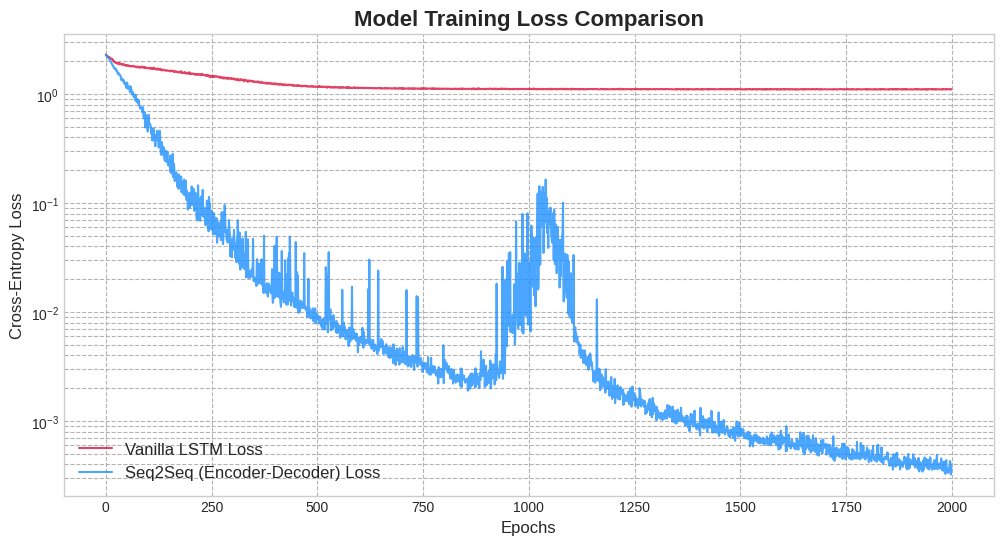

In [7]:
print("\n--- Generating Loss Comparison Plot ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(vanilla_loss, label='Vanilla LSTM Loss', color='crimson', alpha=0.8)
ax.plot(seq2seq_loss, label='Seq2Seq (Encoder-Decoder) Loss', color='dodgerblue', alpha=0.8)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax.set_title('Model Training Loss Comparison', fontsize=16, weight='bold')
ax.legend(fontsize=12)
ax.set_yscale('log')
ax.grid(True, which="both", ls="--", c='0.7')
plt.show()

#Conclusion

The experiment confirms that the

vanilla LSTM architecture is fundamentally unsuited for sequence transformation tasks that require global context, such as reversing a sequence. Its core limitation is its inability to access information from the entire input sequence before generating an output, as it processes inputs and produces outputs in a step-by-step, aligned manner. This structural constraint makes it impossible for the model to correctly perform tasks where the beginning of the output depends on the end of the input.


Conversely, the Encoder-Decoder (Seq2Seq) model proved highly effective for this task. By separating the "reading" of the input with an encoder and the "writing" of the output with a decoder, the model ensures that the generation process is conditioned on the complete context of the input sequence. This architectural advantage is the critical difference and demonstrates why choosing the right model structure is essential for solving complex sequence-to-sequence problems in fields like machine translation and text summarization.